In [10]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import FinanceDataReader as fdr


#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle 


import warnings
warnings.filterwarnings('ignore') 

#  차트 설정
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True

# 데이터 설정

In [2]:
# 한국거래소 상장종목 전체
kospi = fdr.StockListing('KOSPI')
kosdaq = fdr.StockListing('KOSDAQ')

kospi_list = kospi[['Code', 'Name']]
kosdaq_list = kosdaq[['Code', 'Name']]
data_list = pd.concat([kospi_list, kosdaq_list], axis=0)
# kospi_list = kospi[['Code', 'Name']][:10]

# kospi_list 종가 차트
df = fdr.DataReader(data_list['Code'], '2023-11-01', '2023-11-30')
df.columns = data_list['Name']

In [45]:
df.shape

(248, 952)

## 데이터 전처리

In [5]:
# null 처리
print('Null Values =',df.isnull().values.any())
missing_fractions = df.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

df.drop(labels=drop_list, axis=1, inplace=True)
df = df.fillna(method='ffill')
df.head(2) 

Null Values = True


Name,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,삼성전자우,POSCO홀딩스,현대차,NAVER,기아,LG화학,...,한화플러스제2호스팩,에스케이증권제8호스팩,신한제10호스팩,유진스팩9호,엔에이치스팩25호,키움제6호스팩,에스케이증권제10호스팩,유진스팩6호,소프트센우,대호특수강우
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-01,68600,377500,120300,703000,55600,402500,170300,187700,77400,431000,...,2045,2240,2160,2195,2460,2095,2060,2035,9020,7840
2023-11-02,69700,391500,125300,712000,56300,427500,172000,190800,78500,455500,...,2065,2240,2170,2190,2460,2090,2065,2035,9240,7300


## Save data

In [6]:
# save data
# df.to_pickle('../../data/kospi_list_2212-2312.pkl')
df.to_pickle('../../data/krx_list_2311.pkl')

## Load data

In [7]:
# load data
# df = pd.read_pickle('../../data/kospi_list_2212-2312.pkl')
df = pd.read_pickle('../../data/krx_list_2311.pkl')

# 시각화

In [ ]:
# correlation
correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix') 

# Data Transformation
In this step we preparing the data for the clustering.

In [7]:
# Calculate average annual percentage return and volatilities over a theoretical one year period
days = df.shape[0]
returns = df.pct_change().mean() * days
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = df.pct_change().std() * np.sqrt(days)
data=returns
# format the data as a numpy array to feed into the K-Means algorithm
# data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T 

In [8]:
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

,Returns,Volatility
Name,,
삼성전자,-0.090067,-0.842902
LG에너지솔루션,0.981120,1.714357


# Clustering

## Affinity Propagation - 선택

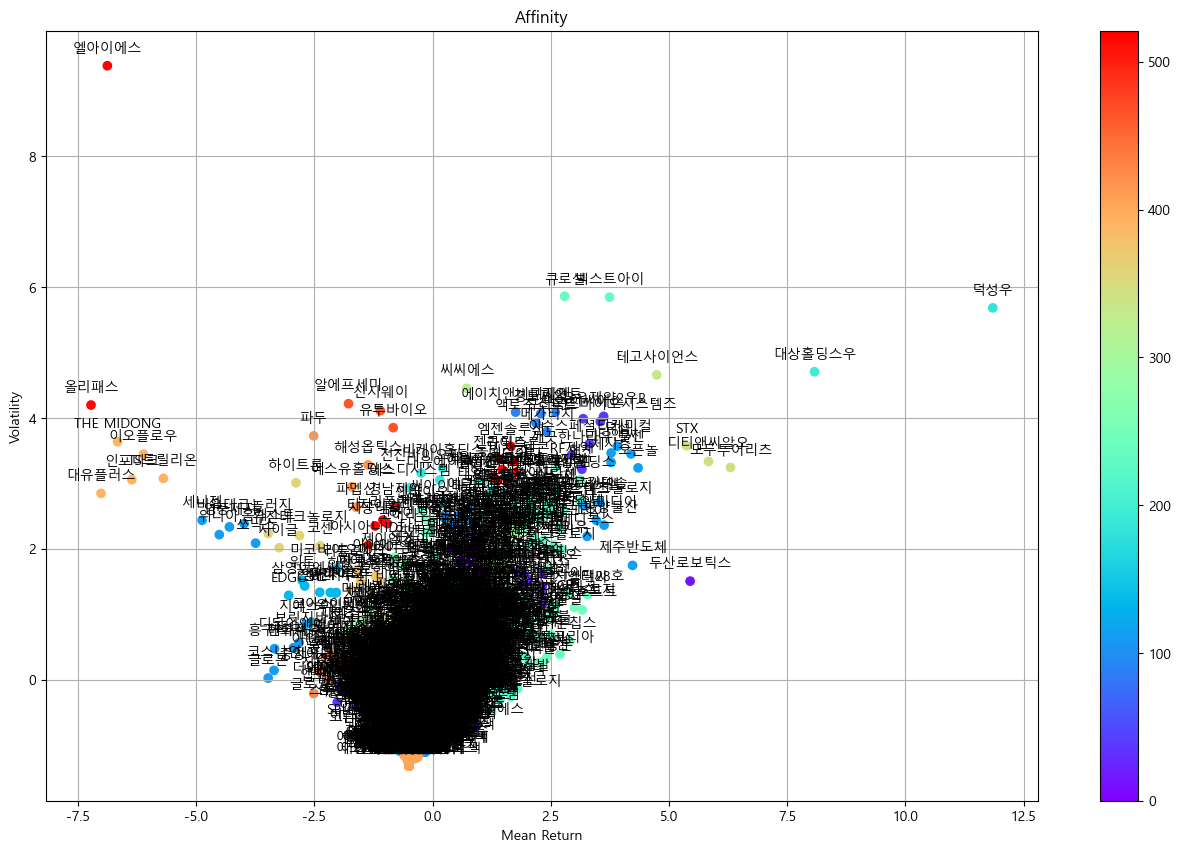

In [12]:
# Affinity Propagation
ap = AffinityPropagation(damping=0.5, max_iter=250, affinity='euclidean')
ap.fit(X)
clust_labels2 = ap.predict(X) 

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=clust_labels2, cmap="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center 

Estimated number of clusters: 522


<Figure size 1400x400 with 0 Axes>

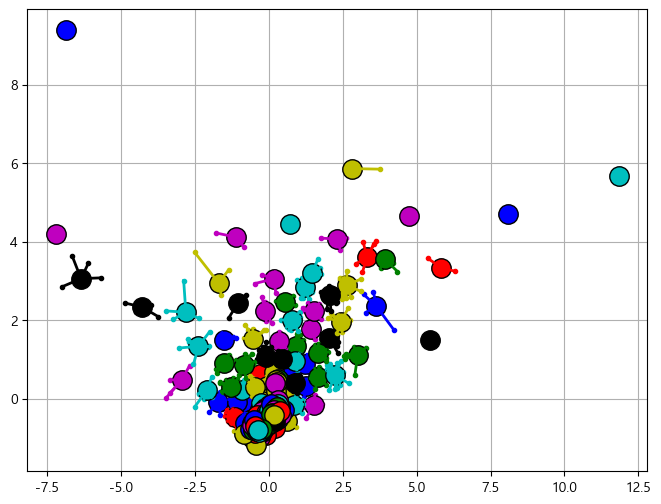

In [14]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

In [ ]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(ap.labels_)],axis = 1)
cluster_label.columns =['Company','Cluster']
cluster_label.sort_values(by=['Cluster']) 

,Company,Cluster
3,삼성바이오로직스,0
4,삼성전자우,1
39,기업은행,1
458,넥센,1
6,현대차,2
...,...,...
456,대성에너지,169
892,제이준코스메틱,169
940,동부건설우,169
720,KC코트렐,169


## K-Means Clustering

In [10]:
nclust=6
k_means = KMeans(n_clusters=nclust)
k_means.fit(X)

C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=6)

In [11]:
centroids, assignments, inertia = k_means.cluster_centers_, k_means.labels_, k_means.inertia_

In [12]:
#Extracting labels 
target_labels = k_means.predict(X)
#Printing the labels
target_labels 

array([3, 0, 0, 3, 3, 4, 3, 0, 3, 0, 0, 4, 3, 0, 3, 3, 3, 3, 0, 3, 0, 3,
       3, 3, 3, 3, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 3, 2, 0, 3, 3,
       4, 0, 3, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 1, 0, 0, 4, 0, 0, 3, 0, 4,
       1, 0, 0, 4, 3, 4, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3,
       0, 0, 4, 3, 3, 3, 3, 0, 0, 0, 0, 4, 3, 3, 4, 0, 0, 4, 3, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3, 0, 4, 0, 3, 0, 3, 0, 3, 0,
       0, 0, 0, 0, 4, 4, 3, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0,
       4, 3, 0, 3, 3, 0, 4, 3, 0, 4, 3, 3, 0, 1, 3, 0, 1, 0, 3, 0, 3, 0,
       0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 3, 1, 0, 0, 0, 3,
       3, 3, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 3, 3, 0, 3, 0, 0, 3, 0, 3, 0,
       0, 0, 3, 4, 0, 0, 3, 0, 3, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 4, 0, 3,
       4, 3, 0, 0, 0, 3, 4, 0, 3, 4, 4, 3, 0, 0, 3, 0, 0, 3, 4, 3, 3, 3,
       3, 0, 0, 3, 1, 3, 4, 0, 3, 3, 0, 3, 0, 3, 4, 3, 0, 3, 3, 0, 1, 3,
       4, 0, 1, 3, 3, 3, 4, 0, 3, 0, 0, 0, 3, 0, 4,

### Finding optimal number of clusters

C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SBA\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMean

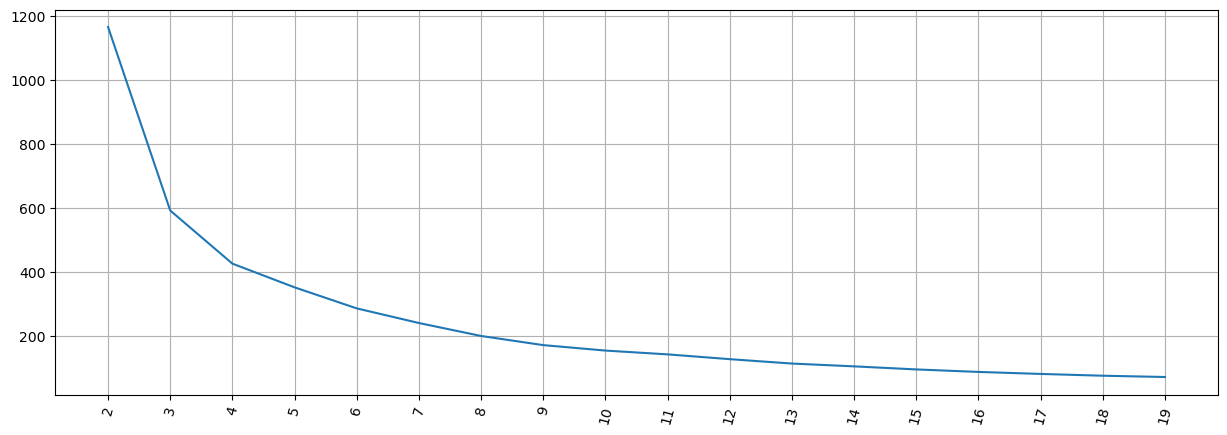

In [13]:
# optimal number
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans_test = KMeans(n_clusters=k)
    kmeans_test.fit(X)
    distorsions.append(kmeans_test.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True) 

### Silhouette score

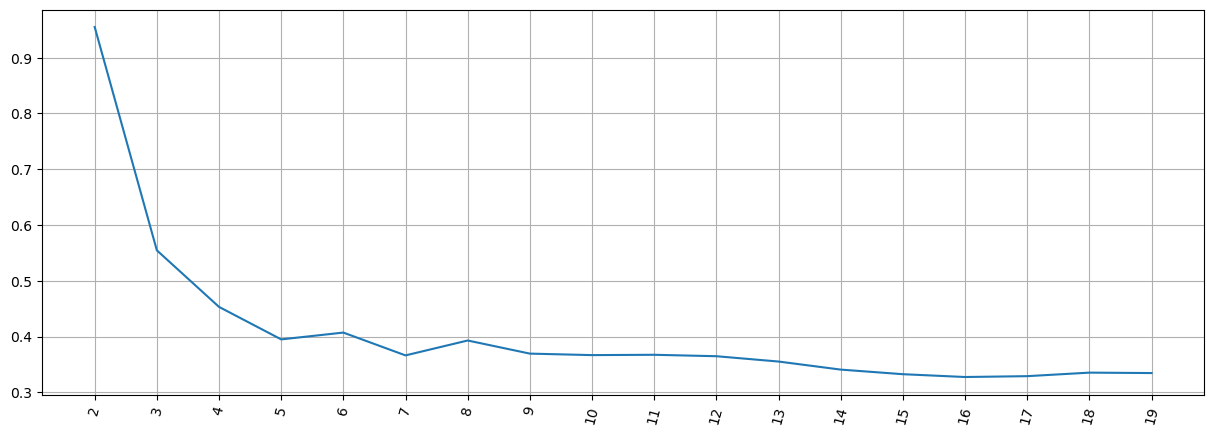

In [17]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans_test = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans_test.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans_test.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True) 

### Cluster Visualisation

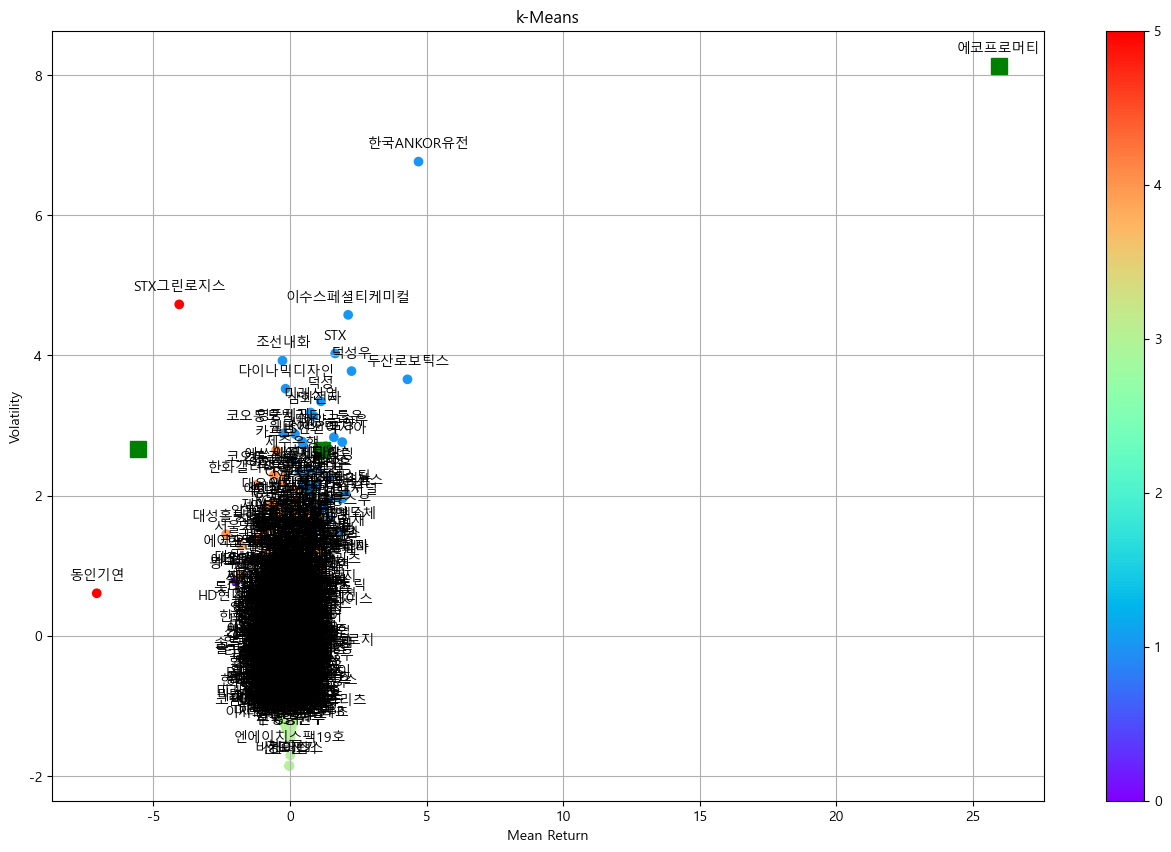

In [21]:
# cluster visualisation
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11) 

### Checking Elements in each cluster

In [ ]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(k_means.labels_)],axis = 1)
cluster_label.columns =['Company','Cluster']
cluster_label.sort_values(by=['Cluster']) 

## Hierarchical Clustering (Agglomerative Clustering)

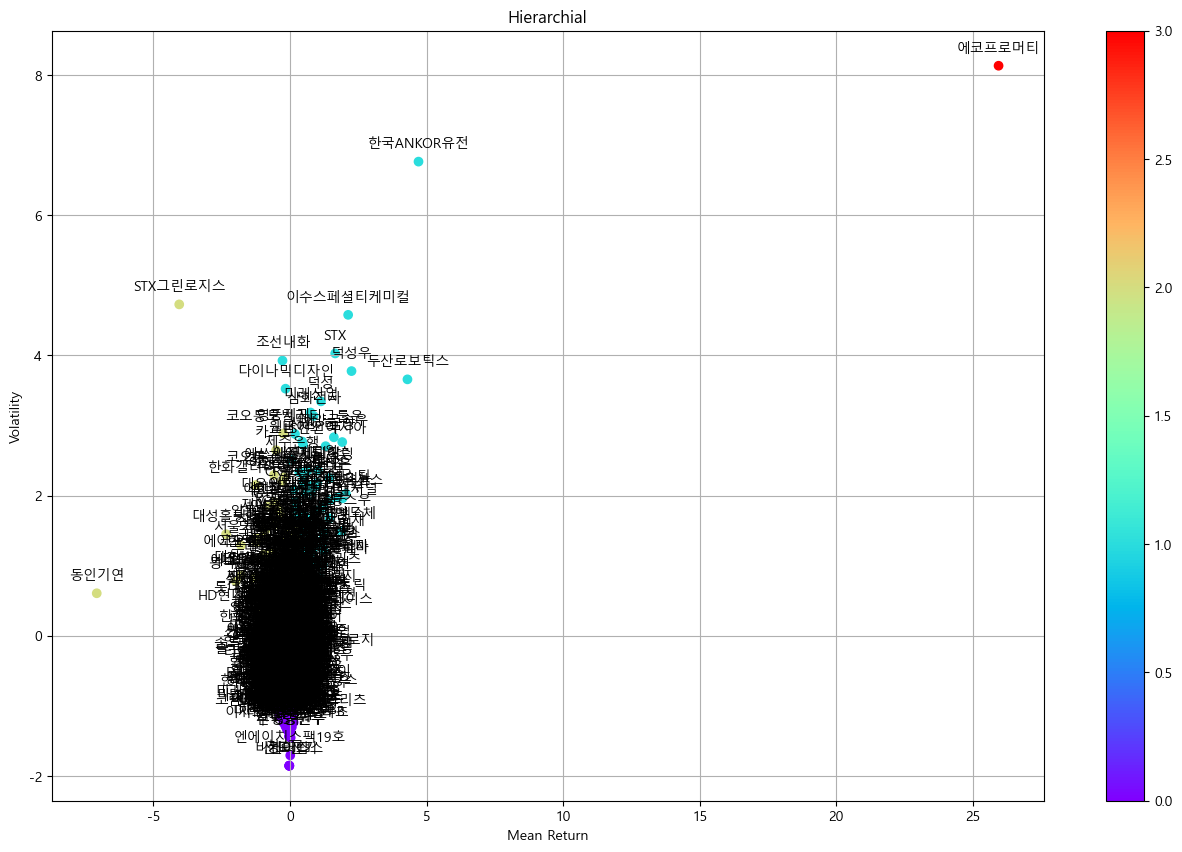

In [22]:
# Hierarchical Clustering (Agglomerative Clustering)
nclust = 4
model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = model.fit_predict(X) 
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchial')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center 

In [23]:
# Visualisation : Building Hierarchy Graph/ Dendogram
#Calulate linkage
Z= linkage(X, method='ward')
Z[0] 

array([572., 655.,   0.,   2.])

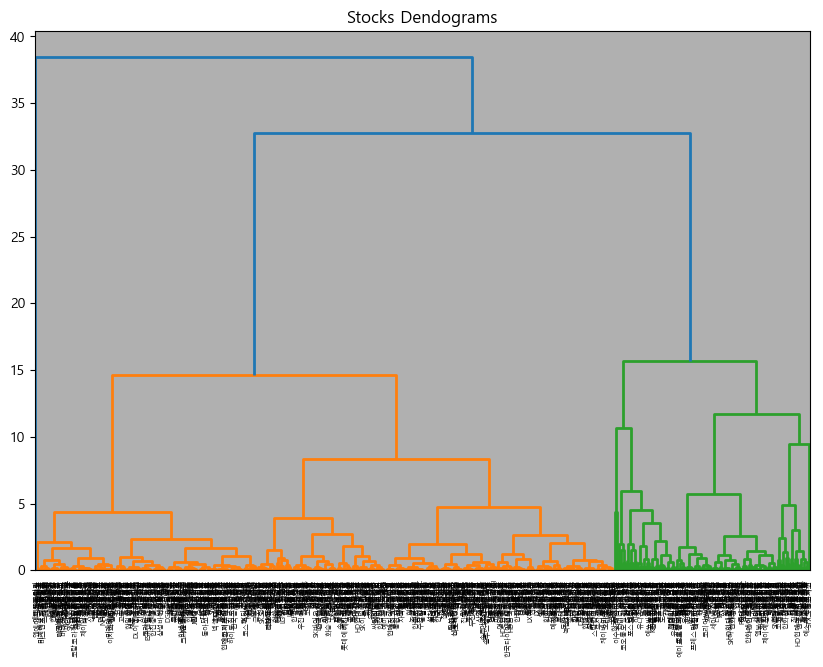

In [24]:
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendograms")
dendrogram(Z,labels = X.index)
plt.show() 

In [25]:
distance_threshold = 2.5
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])

chosen_clusters['cluster'].unique()
# array([4, 5, 2, 3, 1], dtype=int64) 

array([ 2,  4,  7, 18,  8,  3, 15,  6,  5,  1, 13, 24, 17, 10, 21, 16, 14,
        9, 19, 20, 12, 22, 23, 11])

In [26]:
c, coph_dists = cophenet(Z, pdist(X))
c 

0.4527567592300743

In [27]:
# Compare linkage types
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(rescaledDataset) 

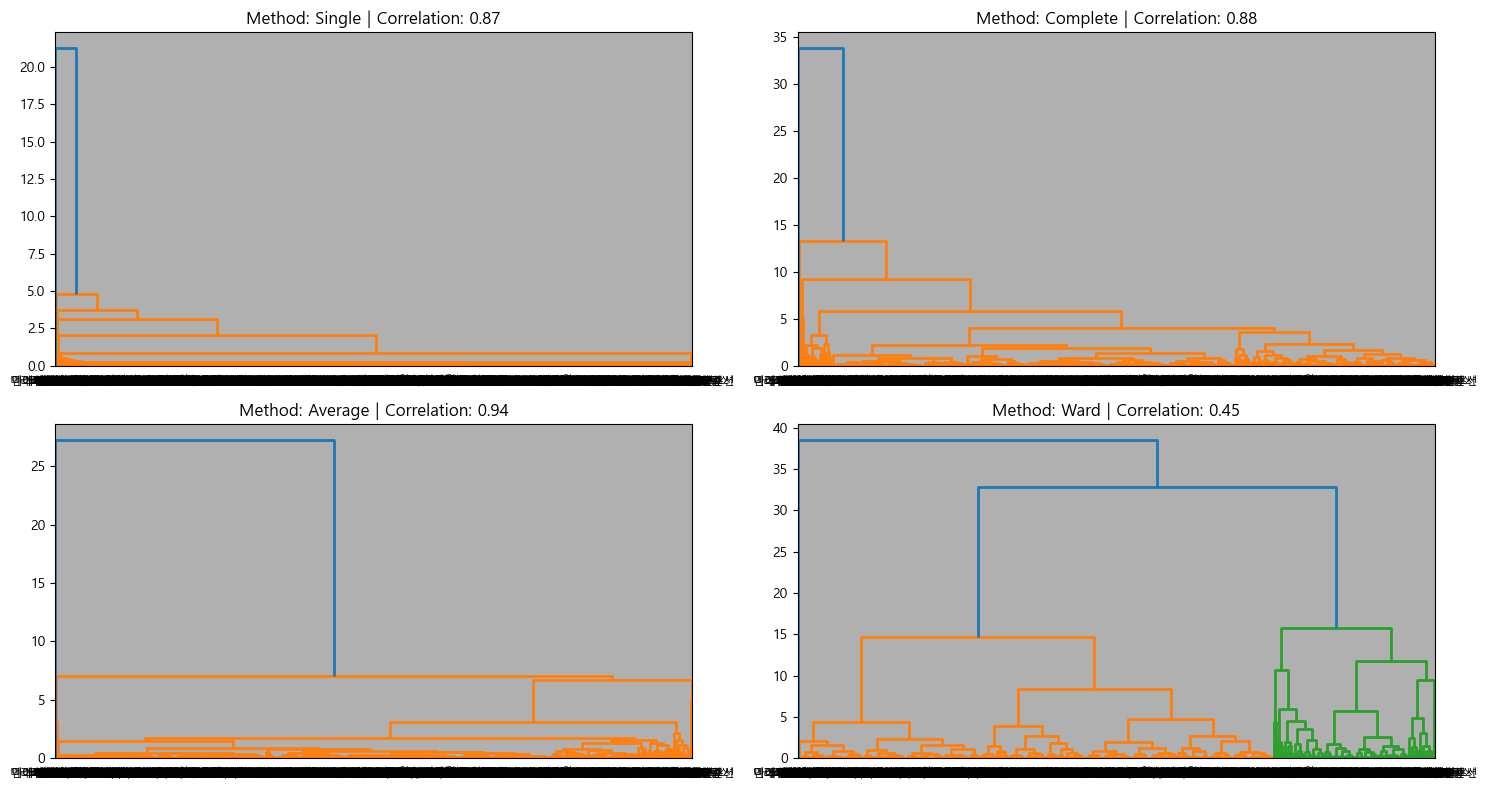

In [28]:
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(X, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, labels=X.index,
        orientation='top', leaf_rotation=0., 
        leaf_font_size=8., ax = axes[i])
    axes[i].set_title('Method: {} | Correlation: {:.2f}'.format(
                                                method.capitalize(), c))
    
fig.tight_layout() 